### Importing Tensorflow and Tensorflow Hub

In [1]:
!pip install --upgrade tensorflow
import tensorflow as tf

!pip install -U tf-hub-nightly
!pip install tfds-nightly
import tensorflow_hub as hub

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0)
     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 3.3MB 2.8MB/s 


### Download MobileNet classifier from TF Hub

In [0]:
classifier_url='https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'

In [0]:
classifier=tf.keras.Sequential([hub.KerasLayer(classifier_url,input_shape=(224,224,3))])

### Try the model on a single image

In [0]:
import numpy as np
import PIL.Image as Image

65536/61306 [================================] - 0s 0us/step


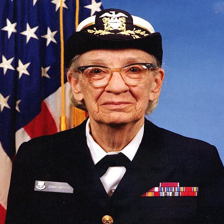

In [5]:
img = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
img = Image.open(img).resize((224,224))
img

In [6]:
result=classifier.predict((np.array(img)/255.0)[np.newaxis, ...])
result

array([[ 0.19971314,  1.0666505 , -0.10109201, ...,  0.1568839 ,
        -0.6055862 , -0.04497601]], dtype=float32)

In [7]:
predicted_class=np.argmax(result[0])
predicted_class

653

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


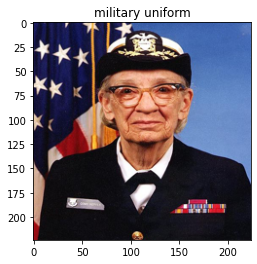

In [9]:
import matplotlib.pyplot as plt

plt.title(imagenet_labels[predicted_class])
plt.imshow(img)
plt.show()

### Transfer Learning

Download dataset

In [10]:
data_root=tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [11]:
image_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data=image_generator.flow_from_directory(str(data_root),target_size=(224,224))

Found 3670 images belonging to 5 classes.


Extract image batch from the dataset

In [12]:
for image_batch,label_batch in image_data:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 224, 224, 3)
(32, 5)


run the classifier on the image batch

In [13]:
result_batch=classifier.predict(image_batch)
result_batch.shape

(32, 1001)

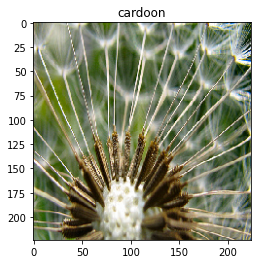

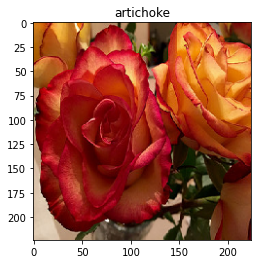

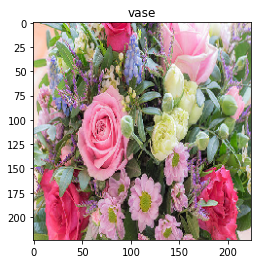

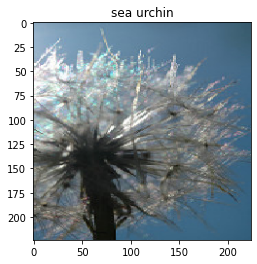

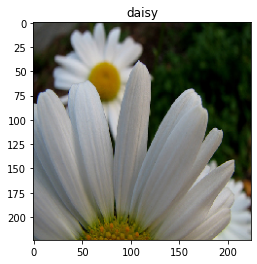

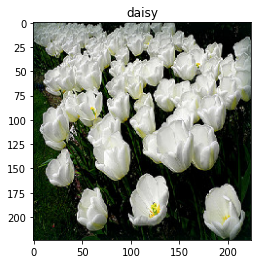

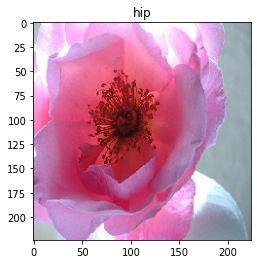

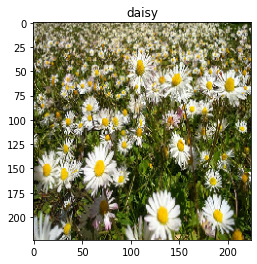

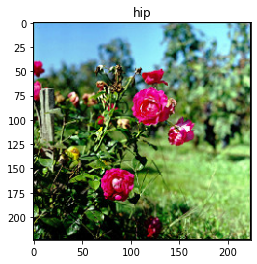

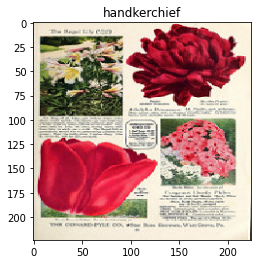

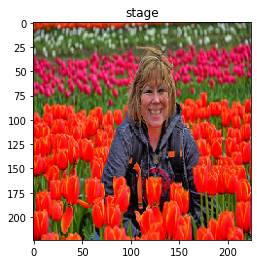

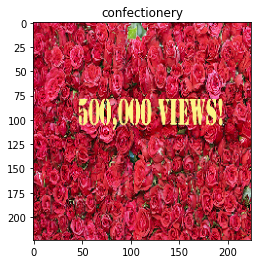

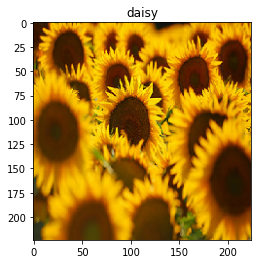

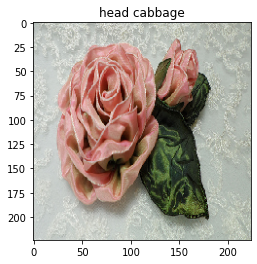

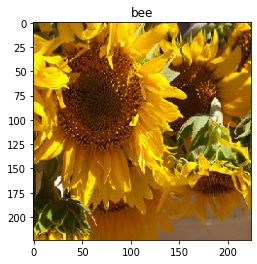

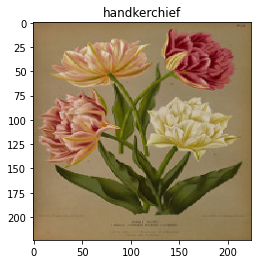

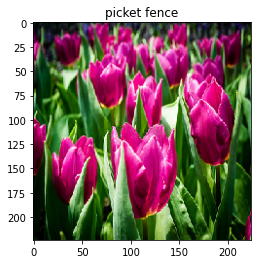

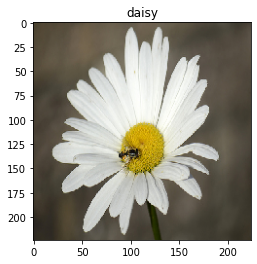

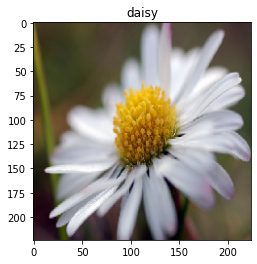

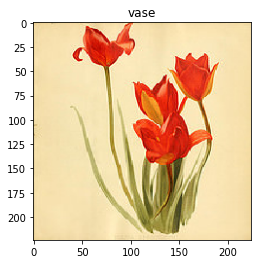

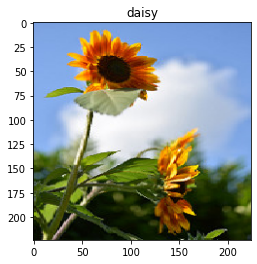

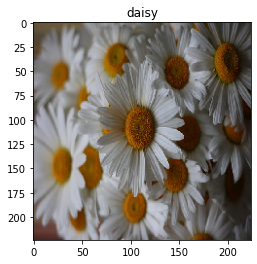

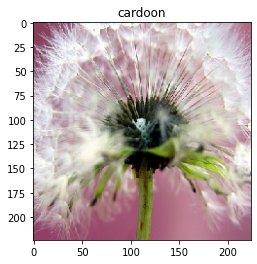

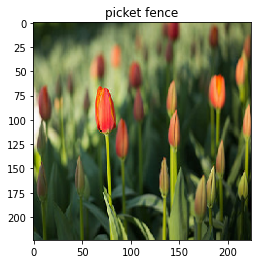

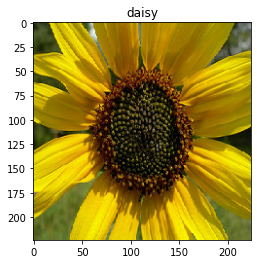

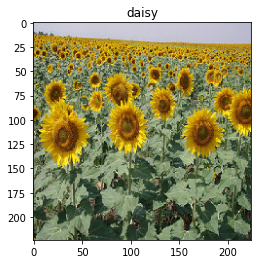

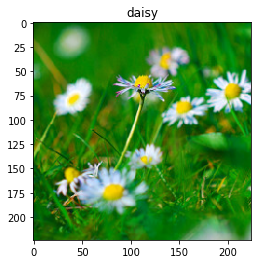

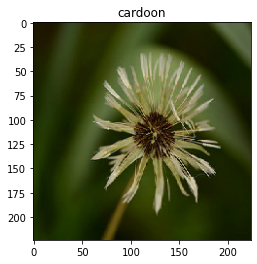

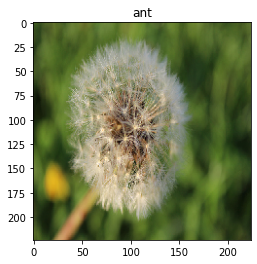

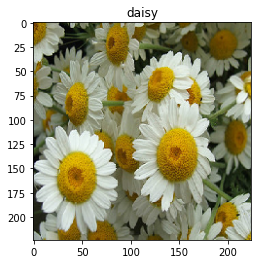

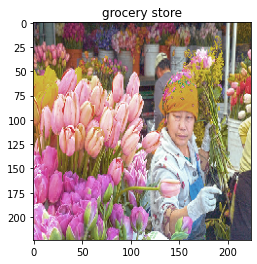

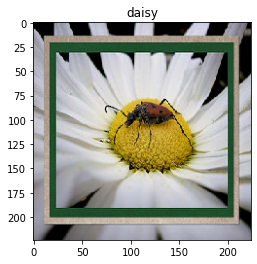

In [14]:
predicted_class_name=imagenet_labels[np.argmax(result_batch,axis=1)]


for i in range(32):
  img=image_batch[i]
  plt.title(predicted_class_name[i])
  plt.imshow(img)
  plt.show()

The classification is not accurate as the model was not trained specific to the flowers dataset.

Download the feature vector from trained model without the classification head

In [15]:
feature_vector_url='https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'

feature_extractor_layer=hub.KerasLayer(feature_vector_url,input_shape=(224,224,3))

feature_batch=feature_extractor_layer(image_batch)
feature_batch.shape

TensorShape([32, 1280])

Freeze the feature extractor layers

In [0]:
feature_extractor_layer.trainable=False

Adding the classification head and completing the model

In [0]:
model=tf.keras.Sequential([feature_extractor_layer,tf.keras.layers.Dense(image_data.num_classes)])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
pred=model(image_batch)
pred.shape

TensorShape([32, 5])

compile the model

In [0]:
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['acc'])

collect loss and accuracy stats for each batch rather than each epoch

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses=[]
    self.batch_acc=[]

  def on_train_batch_end(self,batch,logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [0]:
batch_stats_callback=CollectBatchStats()

In [27]:
history=model.fit_generator(image_data,epochs=5,callbacks=[batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/5
115/115 [==============================] - 127s 1s/step - loss: 0.3686 - acc: 0.8438
Epoch 2/5
115/115 [==============================] - 123s 1s/step - loss: 0.4502 - acc: 0.8750
Epoch 3/5
115/115 [==============================] - 122s 1s/step - loss: 0.3580 - acc: 0.8438
Epoch 4/5
115/115 [==============================] - 122s 1s/step - loss: 0.2589 - acc: 0.9062
Epoch 5/5
115/115 [==============================] - 123s 1s/step - loss: 0.2470 - acc: 0.9062


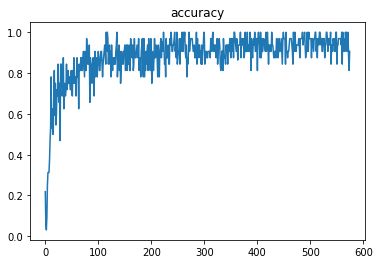

In [28]:
plt.title('accuracy')
plt.plot(batch_stats_callback.batch_acc)
plt.show()

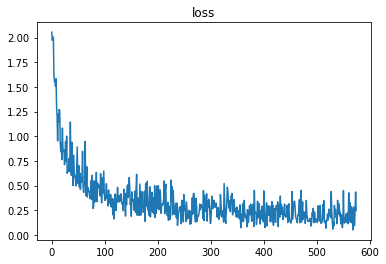

In [29]:
plt.plot(batch_stats_callback.batch_losses)
plt.title('loss')
plt.show()

Checking the predictions

In [30]:
class_names=sorted(image_data.class_indices.items(),key=lambda pair:pair[1])
class_names=np.array([key.title() for key,value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [0]:
pred_batch=model.predict(image_batch)
pred_id=np.argmax(pred_batch,axis=-1)
pred_class=class_names[pred_id]

In [0]:
label_id=np.argmax(label_batch,axis=-1)

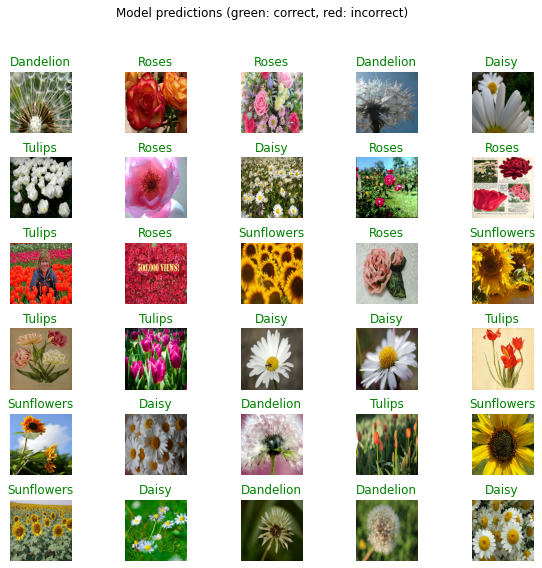

In [46]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=.4)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if pred_id[n] == label_id[n] else "red"
  plt.title(pred_class[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

export the model

In [35]:
import time
t=time.time()

export_path='/tmp/saved_models/{}'.format(int(t))
model.save(export_path,save_format='tf')
export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1591936988/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1591936988/assets


'/tmp/saved_models/1591936988'

In [0]:
reloaded = tf.keras.models.load_model(export_path)

In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [38]:
abs(reloaded_result_batch - result_batch).max()

0.0